<a href="https://colab.research.google.com/github/taechanha/inverseDesignMetaMatl/blob/main/%5Br%5D_Adj_%26_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################

import numpy as np
import matplotlib.pyplot as plt

f = open("/content/dataset_2.txt", 'r')
data = []
length = 0
for i in f:
  new = []
  new.append(i)
  data.append(new)

  # length of dataset
  length += 1

f.close()

# create dataset from data
dataset = []
for i in range(length):
  new = []
  for j in data[i][0].split(','):
    new.append(float(j))
  dataset.append(new)


# trim out label from dataset
# Ex Ey Ez
label = []
new = []
for line in dataset:
  tmp = []
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.reverse()
  label.append(tmp)

print("label.shape: ", np.array(label).shape)


# create edge_index
edge_mat = np.zeros(shape=(27,27))
edge_index = []

for e in range(len(dataset)):
  for i in range(0, 27):
    for j in range(i+1, 27):
      edge_mat[i][j] = dataset[e].pop(0)
  edge_index.append(edge_mat + edge_mat.T)


# whole dataset to Tensor & train/test split
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

edge_index = torch.FloatTensor(edge_index)
label = torch.FloatTensor(label)

split = int(length * 0.8)

x_train = edge_index[:split]
y_train = label[:split]
x_val = edge_index[split:]
y_val = label[split:]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

label.shape:  (2000, 3)
x_train, y_train, x_val shape:  torch.Size([1600, 27, 27]) torch.Size([1600, 3]) torch.Size([400, 27, 27])


In [2]:
x_train = edge_index[:split]
y_train = label[:split][:, 0]
x_val = edge_index[split:]
y_val = label[split:][:, 0]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

x_train, y_train, x_val shape:  torch.Size([1600, 27, 27]) torch.Size([1600]) torch.Size([400, 27, 27])


In [3]:
y_train.shape, y_val.shape

(torch.Size([1600]), torch.Size([400]))

In [4]:
def r2(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [5]:
epochs = 500

In [8]:
def train(model, train_losses, epoch):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda().float(), y.cuda()
        optimizer.zero_grad()
        o = model(x)
        loss = loss_function(o.squeeze(), y)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print('====> Epoch: {} loss: {:.4f}'.format(e, train_loss / len(train_loader)))
    train_losses.append(train_loss / len(train_loader))

def test(model, val_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            loss = loss_function(o.squeeze(), y)
            
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))
    val_losses.append(test_loss / len(test_loader))

def test_pred(model):
    y_pred = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            y_pred.append(o)

            loss = loss_function(o.squeeze(), y)
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

    return y_pred

In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 2)
        self.fc5 = nn.Linear(2, 1)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)

        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=1, bias=True)
)


In [200]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

11865

In [210]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_function = nn.MSELoss()
epochs = 200

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 1.8649
====> Test set loss: 14.3648
====> Epoch: 2 loss: 1.4478
====> Test set loss: 14.2455
====> Epoch: 3 loss: 1.2479
====> Test set loss: 14.2580
====> Epoch: 4 loss: 1.1412
====> Test set loss: 14.1296
====> Epoch: 5 loss: 1.0741
====> Test set loss: 14.1706
====> Epoch: 6 loss: 1.0256
====> Test set loss: 14.1324
====> Epoch: 7 loss: 0.9952
====> Test set loss: 14.1428
====> Epoch: 8 loss: 0.9675
====> Test set loss: 14.1092
====> Epoch: 9 loss: 0.9483
====> Test set loss: 14.1378
====> Epoch: 10 loss: 0.9320
====> Test set loss: 14.1190
====> Epoch: 11 loss: 0.9179
====> Test set loss: 14.1073
====> Epoch: 12 loss: 0.9059
====> Test set loss: 14.1596
====> Epoch: 13 loss: 0.8964
====> Test set loss: 14.1207
====> Epoch: 14 loss: 0.8908
====> Test set loss: 14.1386
====> Epoch: 15 loss: 0.8844
====> Test set loss: 14.1053


KeyboardInterrupt: ignored

In [211]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.5039


In [212]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(0.5963, device='cuda:0', grad_fn=<RsubBackward1>)

In [82]:
y1 = y_pred

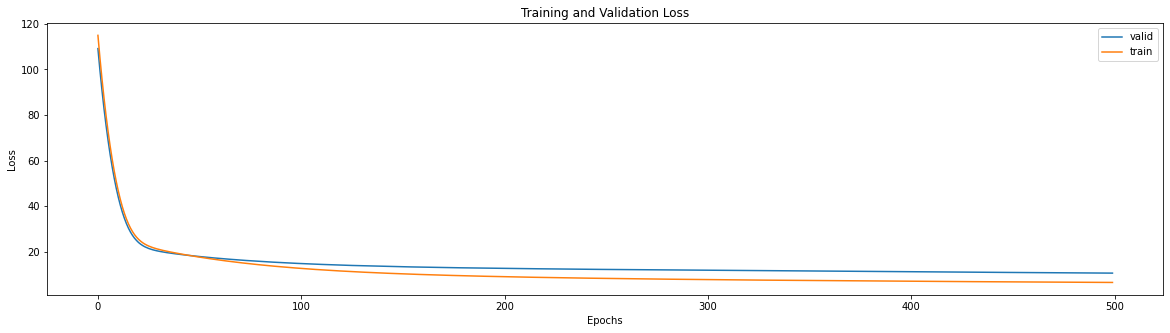

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(0.6933, device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
#

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 16)
        self.fc2 = nn.Linear(16, 1)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

11697

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 117

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

RuntimeError: ignored

In [ ]:
y2 = y_pred

In [ ]:
y_pred = test_pred(model)
# [torch(4,3), torch(4,3), ... 100개]를 torch [400, 3]으로 변환
y_pred = torch.cat((y_pred), 0)
y_pred.shape

In [ ]:
torch.argmin(torch.tensor(y2))

ValueError: ignored

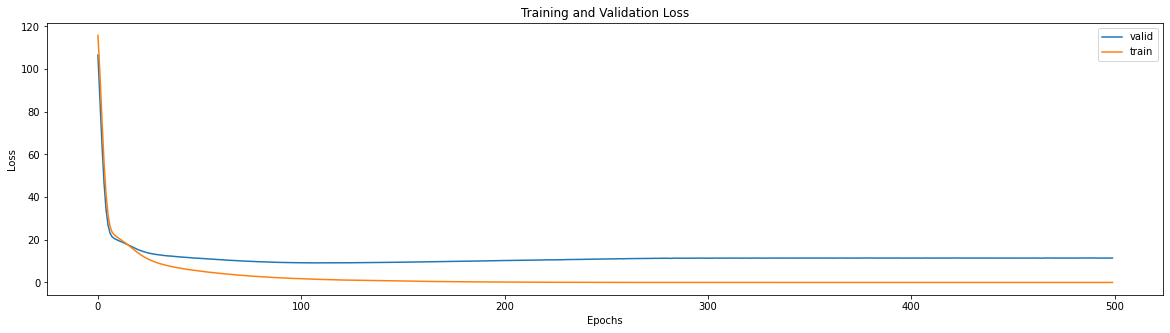

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.1316


In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(0.6711, device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
#

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 32)
        self.fc2 = nn.Linear(32, 1)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

23393

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 115.7770
====> Test set loss: 101.7309
====> Epoch: 2 loss: 86.7515
====> Test set loss: 69.8029
====> Epoch: 3 loss: 56.5455
====> Test set loss: 42.9710
====> Epoch: 4 loss: 35.7865
====> Test set loss: 28.0231
====> Epoch: 5 loss: 26.2275
====> Test set loss: 22.6708
====> Epoch: 6 loss: 22.8976
====> Test set loss: 20.8242
====> Epoch: 7 loss: 21.5491
====> Test set loss: 20.0508
====> Epoch: 8 loss: 20.6231
====> Test set loss: 19.4580
====> Epoch: 9 loss: 19.7488
====> Test set loss: 18.9166
====> Epoch: 10 loss: 18.8458
====> Test set loss: 18.3830
====> Epoch: 11 loss: 17.9075
====> Test set loss: 17.8178
====> Epoch: 12 loss: 16.9174
====> Test set loss: 17.2440
====> Epoch: 13 loss: 15.9093
====> Test set loss: 16.6383
====> Epoch: 14 loss: 14.9029
====> Test set loss: 16.0498
====> Epoch: 15 loss: 13.9220
====> Test set loss: 15.5034
====> Epoch: 16 loss: 12.9991
====> Test set loss: 15.0013
====> Epoch: 17 loss: 12.1316
====> Test set loss: 14.5178
====

KeyboardInterrupt: ignored

In [ ]:
y3 = y_pred

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 2.8025


In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

In [ ]:
#

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 64)
        self.fc2 = nn.Linear(64, 1)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=364, bias=True)
  (fc2): Linear(in_features=364, out_features=182, bias=True)
  (fc3): Linear(in_features=182, out_features=91, bias=True)
  (fc4): Linear(in_features=91, out_features=1, bias=True)
)


In [ ]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

348895

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = epochs

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 38.6767
====> Test set loss: 21.8808
====> Epoch: 2 loss: 20.1779
====> Test set loss: 18.3174
====> Epoch: 3 loss: 12.9671
====> Test set loss: 15.2371
====> Epoch: 4 loss: 7.7493
====> Test set loss: 14.0519
====> Epoch: 5 loss: 4.4304
====> Test set loss: 12.7256
====> Epoch: 6 loss: 2.3621
====> Test set loss: 11.8337
====> Epoch: 7 loss: 1.2242
====> Test set loss: 11.7461
====> Epoch: 8 loss: 0.5531
====> Test set loss: 11.6483
====> Epoch: 9 loss: 0.2513
====> Test set loss: 11.4328
====> Epoch: 10 loss: 0.1152
====> Test set loss: 11.4306
====> Epoch: 11 loss: 0.0561
====> Test set loss: 11.4027
====> Epoch: 12 loss: 0.0414
====> Test set loss: 11.3603
====> Epoch: 13 loss: 0.0748
====> Test set loss: 11.5374
====> Epoch: 14 loss: 0.2372
====> Test set loss: 11.6470
====> Epoch: 15 loss: 0.5702
====> Test set loss: 11.5077
====> Epoch: 16 loss: 0.6402
====> Test set loss: 11.8161
====> Epoch: 17 loss: 0.4219
====> Test set loss: 11.5147
====> Epoch: 18 loss

In [ ]:
y4 = y_pred

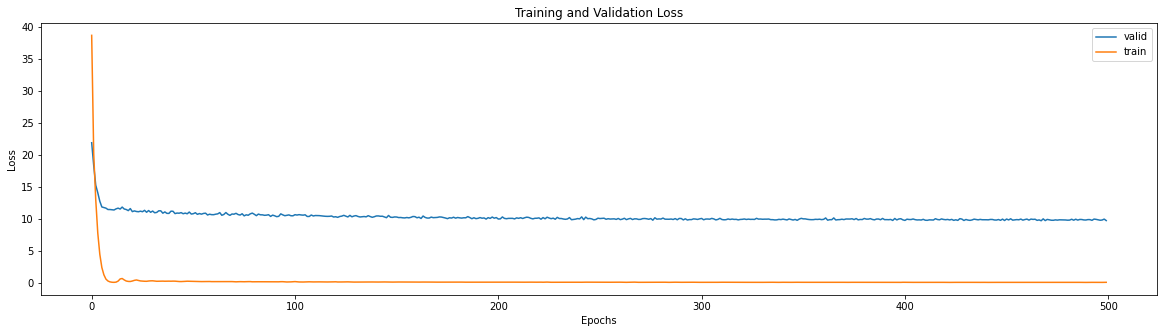

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.1349


In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

In [ ]:
#

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 128)
        self.fc2 = nn.Linear(128, 1)
        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

93569

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

RuntimeError: ignored

In [ ]:
y5 = y_pred

NameError: ignored

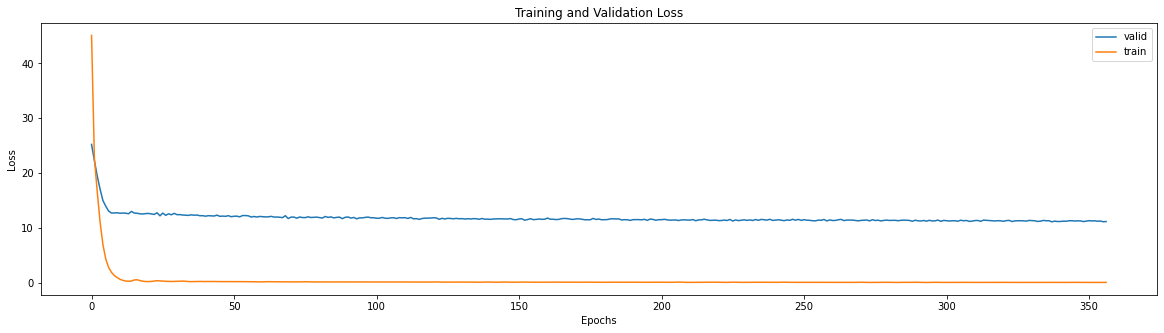

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.2243


In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 256)
        self.fc2 = nn.Linear(256, 1)
        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

In [ ]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

In [ ]:
y6 = y_pred

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

In [ ]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())